# Fraud Detection
## Author: Erdem Tosun

### ======================================
### 1. Installing Required Libraries
### ======================================


In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

### ======================================
### 2. Data Upload and Review
### ======================================


In [13]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


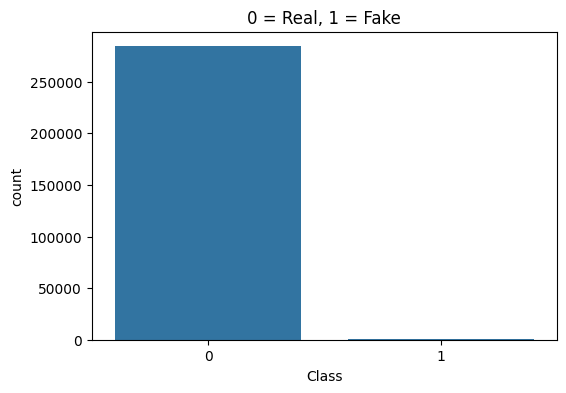

💡 Fake ratio : 0.0017 (%0.17)


In [14]:
#Class Dist.
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Class')
plt.title("0 = Real, 1 = Fake")
plt.show()

# Ratio
fraud_ratio = df['Class'].value_counts(normalize=True)[1]
print(f"💡 Fake ratio : {fraud_ratio:.4f} (%{fraud_ratio*100:.2f})")

### ======================================
### 3. Feature Engineering
### ======================================


In [15]:
# Feature and Target
X = df.drop(columns=['Class'])
y = df['Class']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Balancing with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"New class distrubition: {np.bincount(y_res)}")

New class distrubition: [227451 227451]


### ======================================
### 4. Model Training
### ======================================


In [16]:
# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### Prediction



In [19]:
# Prediction
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"🎯 ROC-AUC: {roc_auc:.4f}")

# Classification Report
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))



🎯 ROC-AUC: 0.9831

📋 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.86      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



### ======================================
### 5. Visualizing Model
### ======================================


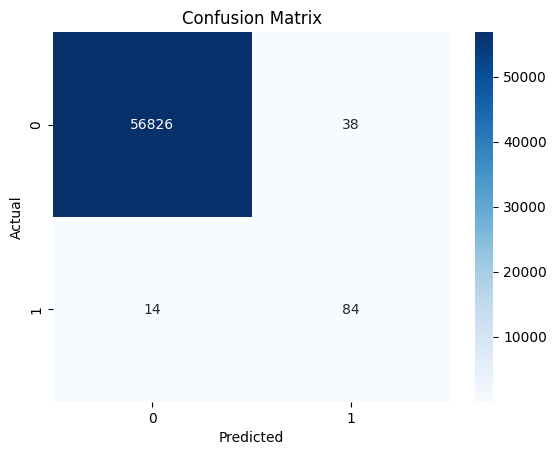

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

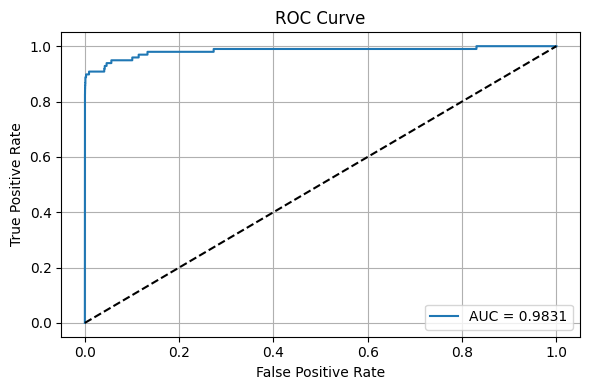

In [21]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

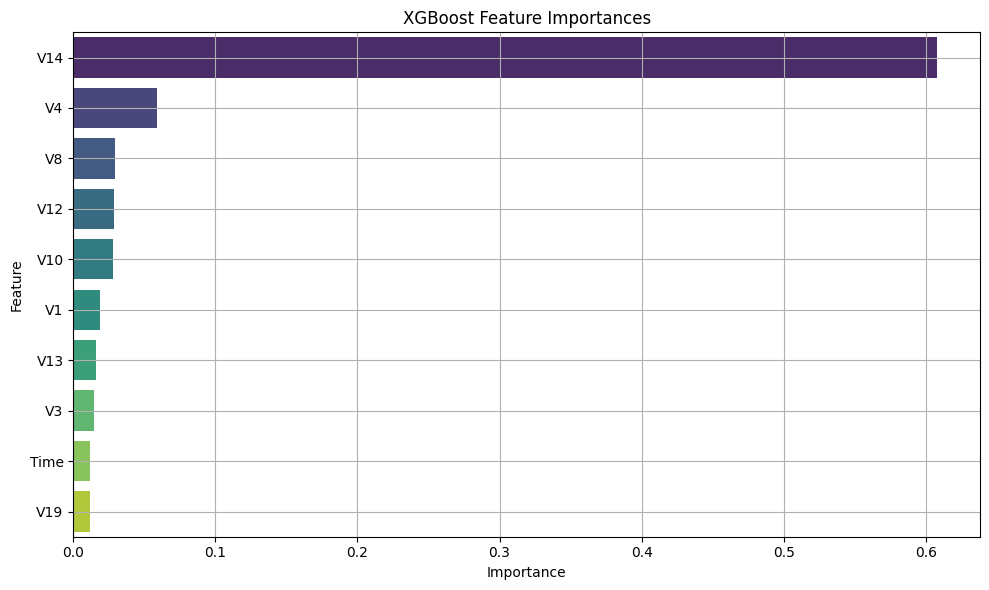

In [22]:
feature_names = df.drop(columns='Class').columns
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("XGBoost Feature Importances")
plt.grid()
plt.tight_layout()
plt.show()

### ======================================
### 6. Saving Model
### ======================================


In [23]:
import joblib

# Save
joblib.dump(xgb_model, "models/fraud_detector_xgb.pkl")
print(" Model saved: models/fraud_detector_xgb.pkl")

 Model saved: models/fraud_detector_xgb.pkl
